In [1]:
%pip install torch torchvision pytorch-lightning wandb matplotlib numpy scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


# Library Import

In [6]:
import os
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm.auto import tqdm

from helper_functions import train_and_evaluate, save_model, save_history

In [4]:
# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_palette("deep")

# Data Loading


In [1]:
data_path = '100-bird-species'

### Data Augmentation

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.dataset = datasets.ImageFolder(
            root=self.data_path, transform=self.transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, fill=144),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

train_dataset = CustomDataset(f'{data_path}/train', transform)
test_dataset = CustomDataset(f'{data_path}/test', transform)
valid_dataset = CustomDataset(f'{data_path}/valid', transform)

In [9]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(84635, 2625, 2625)

In [ ]:
# # REMARK: for testing purposes, reduce the dataset to 10% of the original size
# train_dataset.dataset.samples = train_dataset.dataset.samples[:int(
#     len(train_dataset)*0.1)]
# test_dataset.dataset.samples = test_dataset.dataset.samples[:int(
#     len(test_dataset)*0.1)]
# valid_dataset.dataset.samples = valid_dataset.dataset.samples[:int(
#     len(valid_dataset)*0.1)]

# len(train_dataset), len(test_dataset), len(valid_dataset)

In [10]:
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

len(train_loader), len(test_loader), len(valid_loader)

(2645, 83, 83)

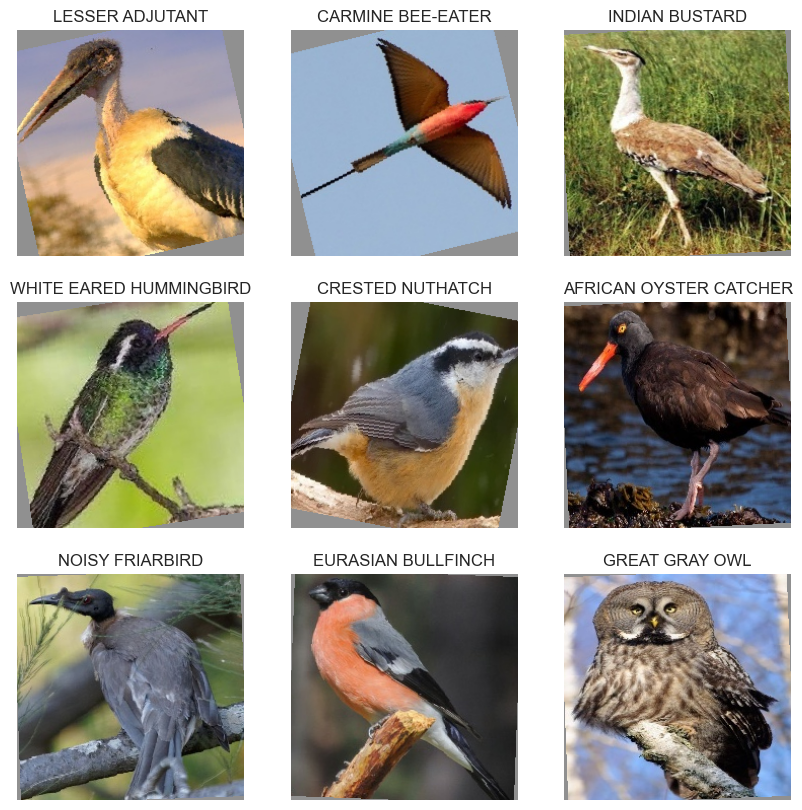

In [11]:
# Random plot some images in the training dataset
class_names = train_dataset.classes

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = np.random.randint(len(train_dataset))
        img, label = train_dataset[idx]
        ax[i, j].imshow(img.permute(1, 2, 0))
        ax[i, j].set_title(class_names[label])
        ax[i, j].axis('off')

# Model Building

### Hyperparameters

In [12]:
# HYPERPARAMETERS
# image
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
CLASSES = len(train_dataset.classes)
LABELS = train_dataset.classes

# training
SEED = 42
DEVICE = "mps" if torch.backends.mps.is_available(
) else "cuda" if torch.cuda.is_available() else "cpu"
GROWTH_RATE = 16

In [13]:
# mps only for apple devices with apple silicon, cuda for nvidia gpu, else cpu
DEVICE

'mps'

## DenseNet

### Class and Instance

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate,
                               kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        return torch.cat([x, out], 1)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([DenseLayer(in_channels + i * growth_rate, growth_rate)
                                     for i in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_classes=1000):
        super(DenseNet, self).__init__()

        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dense blocks
        num_features = 64
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_features, num_layers, growth_rate)
            self.features.add_module(f'denseblock{i+1}', block)
            num_features += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = TransitionLayer(num_features, num_features // 2)
                self.features.add_module(f'transition{i+1}', trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
# create a model instance
torch.manual_seed(SEED)
densenet121_v1 = DenseNet(growth_rate=GROWTH_RATE, num_classes=CLASSES)
densenet121_v1.to(DEVICE)

DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

### Functions

In [ ]:
# define the loss function and the optimizer
# modify based on your task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet121_v1.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=CLASSES).to(DEVICE)

# writer to tensorboard
# !!!! remember change the writer name to <model_name>_<version>, dont't overwrite the previous model
writer = SummaryWriter('runs/densenet121_v1')

### Training

In [ ]:
# train the model
history = train_and_evaluate(model=densenet121_v1,
                             train_loader=train_loader,
                             test_loader=test_loader,
                             criterion=criterion,
                             optimizer=optimizer,
                             scheduler=scheduler,
                             accuracy_fn=accuracy_fn,
                             writer=writer,
                             device=DEVICE,
                             start_epoch=6,
                             end_epoch=10,
                             name='densenet121_v1')

Epochs:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 6 | Training:   0%|          | 0/2645 [00:00<?, ?batch/s]

Epoch 6 | Evaluating:   0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 7 | Training:   0%|          | 0/2645 [00:00<?, ?batch/s]

Epoch 7 | Evaluating:   0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 8 | Training:   0%|          | 0/2645 [00:00<?, ?batch/s]

Epoch 8 | Evaluating:   0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 9 | Training:   0%|          | 0/2645 [00:00<?, ?batch/s]

Epoch 9 | Evaluating:   0%|          | 0/83 [00:00<?, ?batch/s]

Epoch 10 | Training:   0%|          | 0/2645 [00:00<?, ?batch/s]

Epoch 10 | Evaluating:   0%|          | 0/83 [00:00<?, ?batch/s]

### Save Model and History

In [ ]:
# save the model
save_model(densenet121_v1, 'densenet121_v1')

PosixPath('models/densenet121_v1.pth')

In [ ]:
# Create DataFrames for train and eval data
train_df = pd.DataFrame(history['train'])
eval_df = pd.DataFrame(history['eval'])

# Add a column to distinguish between train and eval data
train_df['set'] = 'train'
eval_df['set'] = 'eval'

# Combine the two DataFrames
history_df = pd.concat([train_df, eval_df], ignore_index=True)
history_df

epoch      loss  accuracy    set
0      6  1.106347  0.727029  train
1      7  1.000563  0.750074  train
2      8  0.907945  0.771445  train
3      9  0.837230  0.786863  train
4     10  0.773527  0.801728  train
5      6  0.638834  0.833584   eval
6      7  0.695693  0.815136   eval
7      8  0.488435  0.867093   eval
8      9  0.506348  0.856928   eval
9     10  0.419652  0.884036   eval

In [ ]:
# save the history to a csv file
save_history(history_df, 'densenet121_v1')

In [ ]:
def plot_accuracy_loss(df):
    # Separate train and eval data
    train_data = df[df['set'] == 'train']
    eval_data = df[df['set'] == 'eval']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot Loss
    ax1.plot(train_data['epoch'], train_data['loss'], 'b-', label='Train')
    ax1.plot(eval_data['epoch'], eval_data['loss'], 'r-', label='Eval')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Evaluation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(train_data['epoch'], train_data['accuracy'], 'b-', label='Train')
    ax2.plot(eval_data['epoch'], eval_data['accuracy'], 'r-', label='Eval')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Evaluation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
plot_accuracy_loss(history_df)

### Load Model

In [ ]:
# Load model from models
densenet121_v1_trained = DenseNet(growth_rate=GROWTH_RATE, num_classes=CLASSES)
densenet121_v1_trained.load_state_dict(torch.load('models/densenet121_v1.pth'))
densenet121_v1_trained.to(DEVICE)

/var/folders/66/4fld84796yv3g90zfcw891gw0000gn/T/ipykernel_4462/2823307344.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet121_v1_trained.load_state_dict(torch.l

DenseNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(80, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

# Evaluation

## DenseNet

In [25]:
def plot_random_samples_grid(valid_loader, model, classes):
    # Set the model to evaluation mode
    model.eval()

    # Collect 16 random samples from the entire validation set
    images_list = []
    labels_list = []
    predicted_list = []

    while len(images_list) < 16:
        for images, labels in valid_loader:
            if len(images_list) >= 16:
                break

            # Randomly select images from this batch
            for i in range(len(images)):
                if len(images_list) >= 16:
                    break

                image = images[i].unsqueeze(0).to(
                    next(model.parameters()).device)

                with torch.inference_mode():
                    output = model(image)
                    _, predicted = torch.max(output, 1)

                images_list.append(image.squeeze().cpu())
                labels_list.append(labels[i].cpu())
                predicted_list.append(predicted.cpu())

    # Plot the images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    for i in range(16):
        ax = axes[i // 4, i % 4]
        # Convert from CxHxW to HxWxC for plotting
        ax.imshow(images_list[i].permute(1, 2, 0))
        # Check if the prediction is correct
        if predicted_list[i].item() == labels_list[i].item():
            title_color = 'black'

            title_text = f'Pred: {classes[predicted_list[i].item()]} \n Actual: {classes[labels_list[i].item()]}'
        else:
            title_color = 'red'
            title_text = f'Pred: {classes[predicted_list[i].item()]} \n Actual: {classes[labels_list[i].item()]}'

        # Set the title with the appropriate color and boldness
        ax.set_title(title_text, color=title_color, fontweight='bold')
        ax.axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

### Visualize

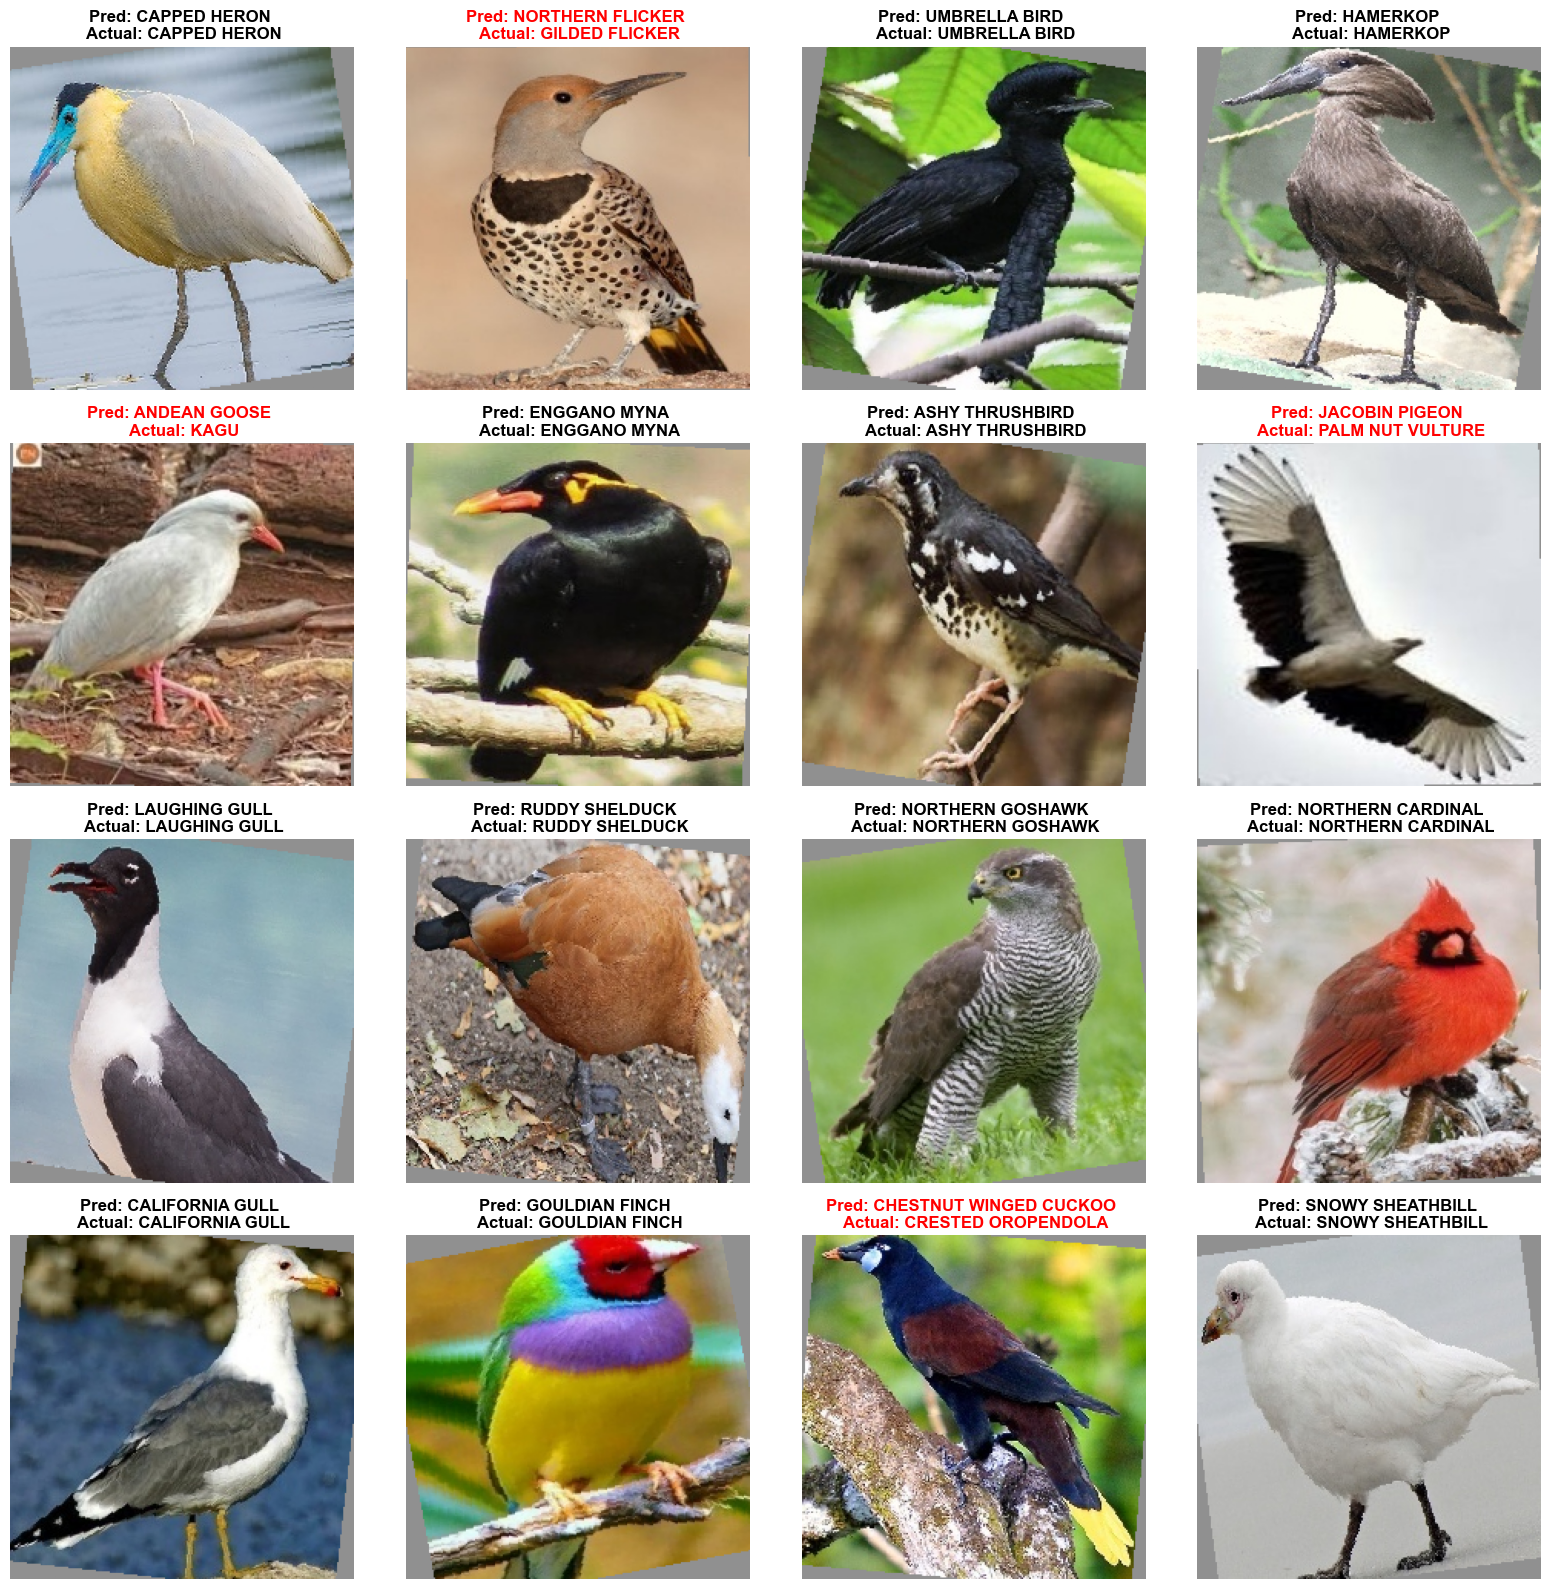

In [27]:
plot_random_samples_grid(valid_loader, densenet121_v1_trained, LABELS)

### Confusion Matrix

In [28]:
def predict_model(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  device: torch.device = 'mps'):
    """eval the model

    Args:
        model (nn.Module): The model to test
        data_loader (torch.utils.data.DataLoader): The data loader for the testing data
        device (torch.device, optional): The device used to train the model. Defaults to 'mps'
    """

    model.eval()
    targets, preds = [], []

    with torch.inference_mode(), tqdm(data_loader, desc=f"Making Prediction") as pbar:
        for input, label in pbar:
            input, label = input.to(device), label.to(device)

            output = model(input)
            pred = output.softmax(dim=1).argmax(dim=1)

            targets.append(label.cpu())
            preds.append(pred.cpu())

        return {
            "name": model.__class__.__name__,
            "targets": targets,
            "preds": preds,
        }

In [29]:
from torch.utils.data import ConcatDataset, DataLoader

# Join the validation and test datasets into a single dataset for evaluation
eval_dataset = ConcatDataset([valid_dataset, test_dataset])
# Create a DataLoader from the combined dataset
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=True)

predictions = predict_model(densenet121_v1_trained, eval_loader, DEVICE)

Making Prediction:   0%|          | 0/165 [00:00<?, ?it/s]

In [30]:
preds = torch.cat(predictions['preds'])
targets = torch.cat(predictions['targets'])

In [32]:
import torchmetrics
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=CLASSES, task="multiclass")

cmat = confmat(preds, targets)

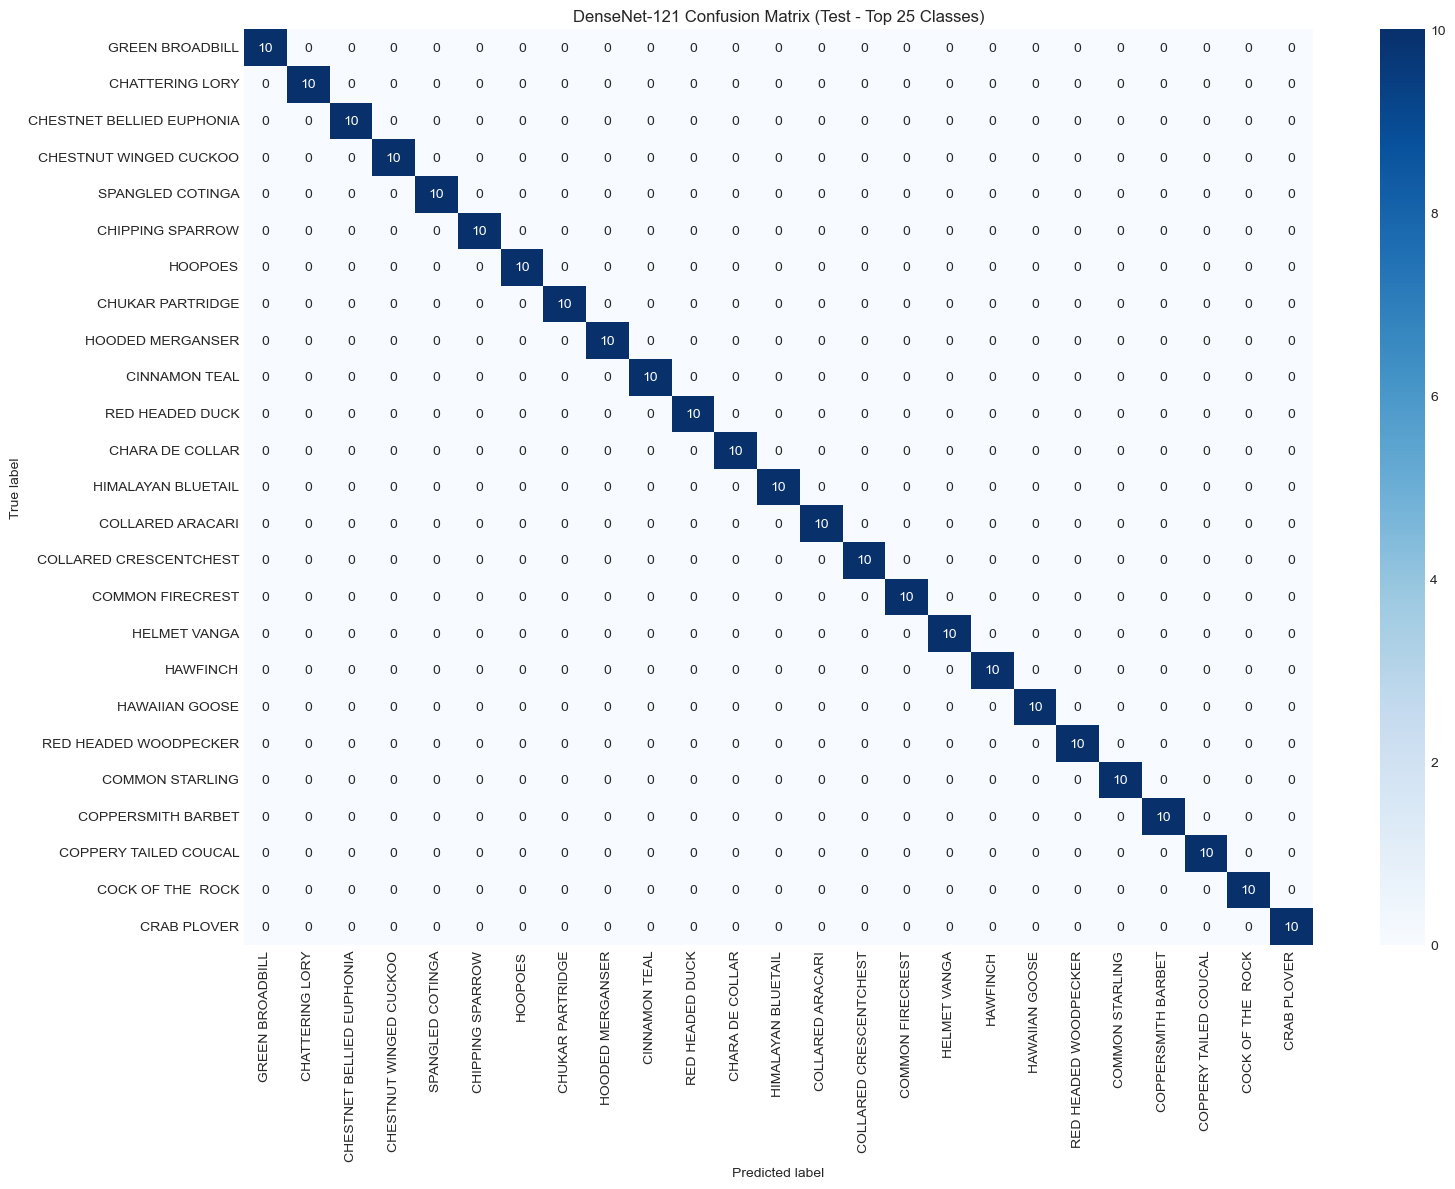

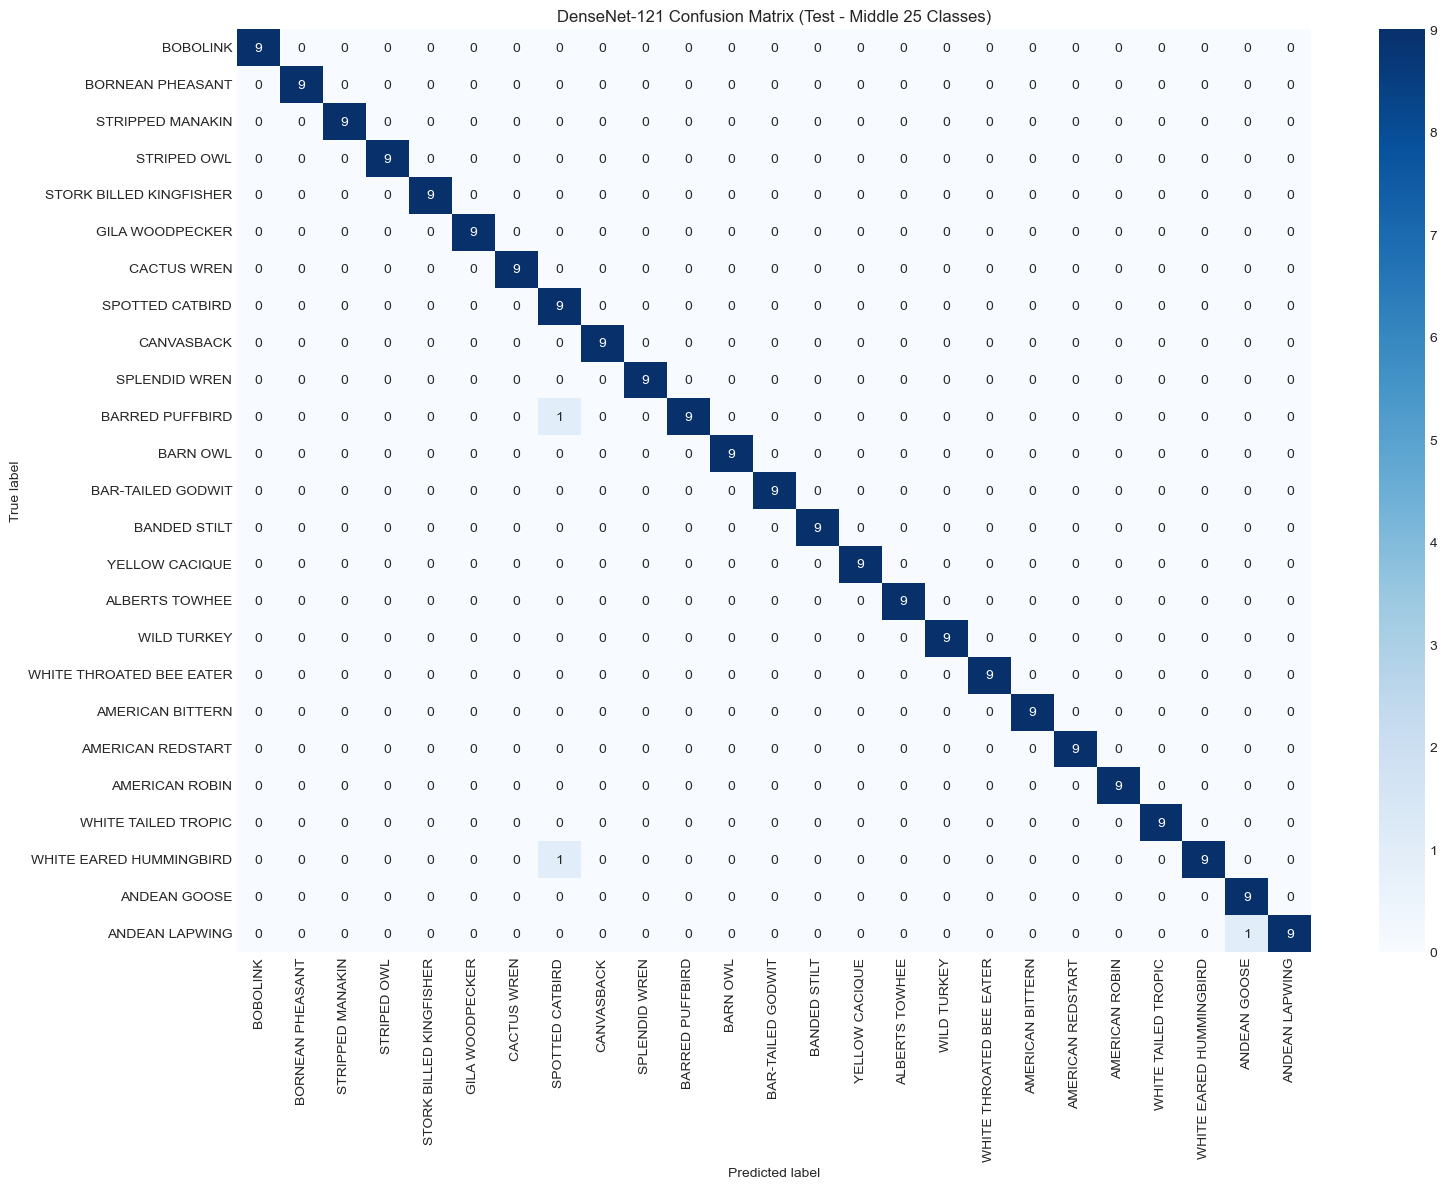

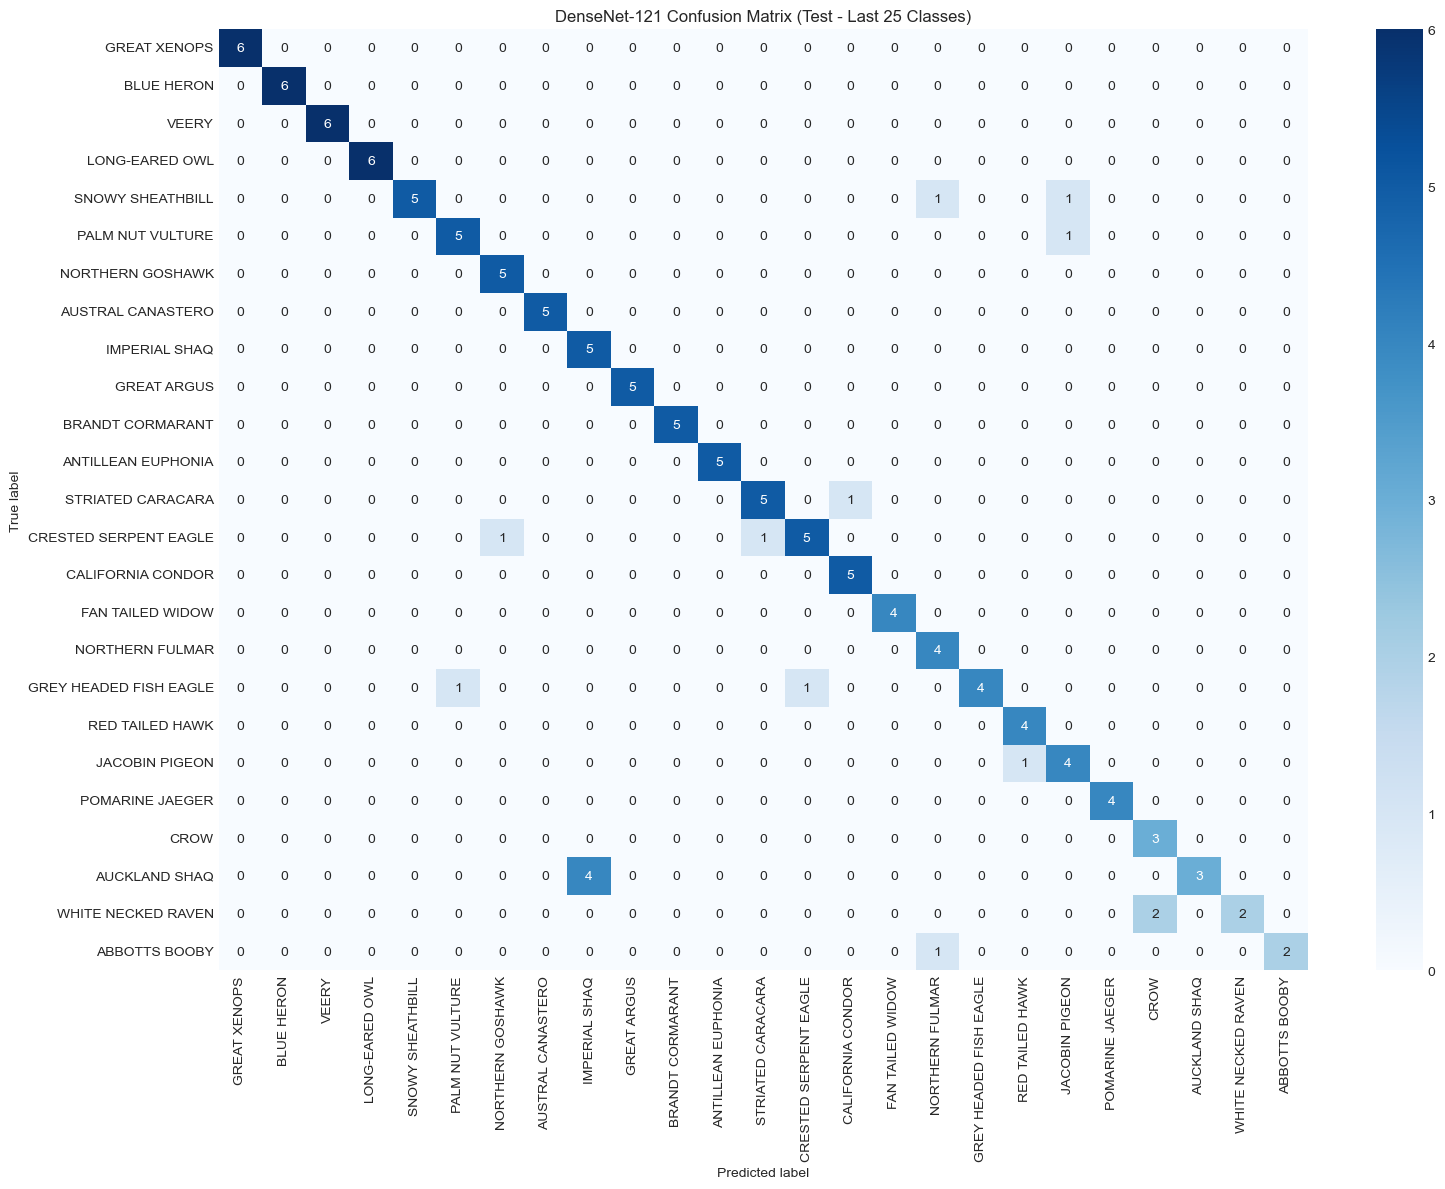

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix_range(title, conf_mat, class_names, range_slice=slice(None)):
    # Sum confusion matrix rows to find most confused classes
    class_errors = conf_mat.sum(axis=1) - conf_mat.diagonal()

    # Get the indices for the specified range using the slice object
    sorted_indices = np.argsort(class_errors)
    selected_indices = sorted_indices[range_slice]

    # Select classes from confusion matrix
    conf_mat_range = conf_mat[selected_indices][:, selected_indices]
    class_names_range = [class_names[i] for i in selected_indices]

    # Plot
    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_mat_range, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_range, yticklabels=class_names_range)
    plt.title(f'{title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# Calculate the start and end indices for the middle 25 classes
mid_count = 25
mid_start = (CLASSES - mid_count) // 2
mid_end = mid_start + mid_count
# Create a slice object for the middle 25 classes
middle_slice = slice(mid_start, mid_end)

# Example usage
plot_confusion_matrix_range(title="DenseNet-121 Confusion Matrix (Test - Top 25 Classes)",
                            conf_mat=cmat.numpy(),
                            class_names=LABELS,
                            range_slice=slice(0, 25))  # Top 25
plot_confusion_matrix_range(title="DenseNet-121 Confusion Matrix (Test - Middle 25 Classes)",
                            conf_mat=cmat.numpy(),
                            class_names=LABELS,
                            range_slice=middle_slice)  # Middle 25
plot_confusion_matrix_range(title="DenseNet-121 Confusion Matrix (Test - Last 25 Classes)",
                            conf_mat=cmat.numpy(),
                            class_names=LABELS,
                            range_slice=slice(-25, None))  # Top 25

### Classification Report

In [34]:
from sklearn.metrics import classification_report

num_classes = CLASSES
target_names = ["Class {}".format(target) for i, target in enumerate(LABELS)]
print(classification_report(targets, preds, target_names=target_names))

                                     precision    recall  f1-score   support

              Class ABBOTTS BABBLER       0.88      0.70      0.78        10
                Class ABBOTTS BOOBY       0.67      0.20      0.31        10
   Class ABYSSINIAN GROUND HORNBILL       0.88      0.70      0.78        10
        Class AFRICAN CROWNED CRANE       0.89      0.80      0.84        10
       Class AFRICAN EMERALD CUCKOO       1.00      1.00      1.00        10
            Class AFRICAN FIREFINCH       0.91      1.00      0.95        10
       Class AFRICAN OYSTER CATCHER       0.71      1.00      0.83        10
        Class AFRICAN PIED HORNBILL       1.00      0.80      0.89        10
          Class AFRICAN PYGMY GOOSE       1.00      1.00      1.00        10
                    Class ALBATROSS       0.67      0.80      0.73        10
               Class ALBERTS TOWHEE       1.00      0.90      0.95        10
         Class ALEXANDRINE PARAKEET       0.91      1.00      0.95        1

In [35]:
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score

metrics = MetricCollection([
    MulticlassAccuracy(CLASSES),
    MulticlassPrecision(CLASSES),
    MulticlassRecall(CLASSES),
    MulticlassF1Score(CLASSES)
])

result = metrics(preds, targets)
# Convert tensor values to Python scalars
result = {k: v.item() if isinstance(v, torch.Tensor)
          else v for k, v in result.items()}

df = pd.DataFrame(result.items(), columns=['Metric', 'Value'])
df

Metric     Value
0   MulticlassAccuracy  0.864952
1  MulticlassPrecision  0.884167
2     MulticlassRecall  0.864952
3    MulticlassF1Score  0.864433

# Model Tuning

### Load model and functions

In [ ]:
# # Load model from models
# def create_model(trial):
#     # Hyperparameters to optimize
#     # Define hyperparameters to optimize
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
#     optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    
#     num_classes = CLASSES

#     model = EfficientNetV2(num_classes=CLASSES)
#     model.load_state_dict(torch.load('models/effnet_v1.pth'))
#     model.to(DEVICE)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     return model, criterion, optimizer, batch_size

In [15]:
import os

import optuna
from optuna.trial import TrialState
from torchvision import datasets
from torchvision import transforms
from optuna.storages import RDBStorage

from helper_functions import train_model, eval_model

In [16]:
CLASSES = len(train_dataset.classes)
EPOCHS = 10
N_TRAIN_EXAMPLES = train_dataset.__len__() * 0.20
N_VALID_EXAMPLES = valid_dataset.__len__() * 0.20
N_TRAIN_EXAMPLES, N_VALID_EXAMPLES

(16927.0, 525.0)

In [17]:
# Step 1: Define the Objective Function

def objective(trial):
    # Define hyperparameters to optimize
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    optimizer_name = trial.suggest_categorical(
        "optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    # Early stopping parameters
    patience = trial.suggest_int('patience', 5, 20)
    min_delta = trial.suggest_float('min_delta', 1e-4, 1e-2, log=True)

    # Data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    model = DenseNet(growth_rate=GROWTH_RATE, num_classes=CLASSES)
    model.load_state_dict(torch.load('models/densenet121_v1.pth'))
    model.to(DEVICE)

    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training loop with early stopping
    best_val_acc = 0
    epochs_no_improve = 0

    epoch_iterator = tqdm(range(
        1, EPOCHS + 1), desc=f"Trial {trial.number} | Epoch", unit="epoch", leave=False)
    for epoch in epoch_iterator:

        model.train()
        epoch_iterator.set_description(
            f"Trial {trial.number} | Train | Epoch {epoch}")

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        epoch_iterator.set_description(
            f"Trial {trial.number} | Valid | Epoch {epoch}")
        model.eval()
        correct = 0
        val_examples = 0
        with torch.inference_mode():
            for batch_idx, (inputs, labels) in enumerate(valid_loader):
                # Limiting validation data.
                if val_examples >= N_VALID_EXAMPLES:
                    break
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                preds = outputs.argmax(dim=1, keepdim=True)
                correct += preds.eq(labels.view_as(preds)).sum().item()
                val_examples += inputs.size(0)

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early stopping
        if accuracy > best_val_acc + min_delta:
            best_val_acc = accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    return best_val_acc


study_name = "densenet-121_optimization"
storage = RDBStorage('sqlite:///db.sqlite3')
# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(
    study_name=study_name, storage=storage, direction='maximize', load_if_exists=True)

# Optimize
study.optimize(objective, n_trials=10)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(
    deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

# Print results
print('Best trial:')
trial = study.best_trial
print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-08-15 05:47:42,288] A new study created in RDB with name: densenet-121_optimization
/var/folders/66/4fld84796yv3g90zfcw891gw0000gn/T/ipykernel_2469/2204729995.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any 

Trial 0 | Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

[I 2024-08-15 09:09:02,260] Trial 0 finished with value: 0.8552380952380952 and parameters: {'batch_size': 8, 'optimizer': 'SGD', 'lr': 0.00014016026512783393, 'patience': 19, 'min_delta': 0.001749463424331606}. Best is trial 0 with value: 0.8552380952380952.


Trial 1 | Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

[I 2024-08-15 12:23:54,222] Trial 1 finished with value: 0.8952380952380953 and parameters: {'batch_size': 16, 'optimizer': 'RMSprop', 'lr': 0.0005317667915089098, 'patience': 12, 'min_delta': 0.000812613980381177}. Best is trial 1 with value: 0.8952380952380953.


Trial 2 | Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]